In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from PIL import Image
import torch.nn.functional as F
import numpy as np

In [2]:
torch.__version__

'1.3.1'

## Define LeNet

In [3]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()

        # input channel = 1, output channel = 6, kernel_size = 5
        # input size = (32, 32), output size = (28, 28)
        self.conv1 = nn.Conv2d(1, 6, 5)
        # input channel = 6, output channel = 16, kernel_size = 5
        # input size = (14, 14), output size = (10, 10)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # input dim = 16*5*5, output dim = 120
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        # input dim = 120, output dim = 84
        self.fc2 = nn.Linear(120, 84)
        # input dim = 84, output dim = 10
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # pool size = 2
        # input size = (28, 28), output size = (14, 14), output channel = 6
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        # pool size = 2
        # input size = (10, 10), output size = (5, 5), output channel = 16
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        # flatten as one dimension
        x = x.view(x.size()[0], -1)
        # input dim = 16*5*5, output dim = 120
        x = F.relu(self.fc1(x))
        # input dim = 120, output dim = 84
        x = F.relu(self.fc2(x))
        # input dim = 84, output dim = 10
        x = self.fc3(x)
        return x

## Define a function to load MNIST

In [4]:
def load_data(train_batch_size, test_batch_size):
    # Fetch training data: total 60000 samples
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.Resize((32, 32)),
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=train_batch_size, shuffle=True)

    # Fetch test data: total 10000 samples
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=False, transform=transforms.Compose([
            transforms.Resize((32, 32)),
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])),
        batch_size=test_batch_size, shuffle=True)

    return (train_loader, test_loader)

## Define a function to train model

In [5]:
def train(model, optimizer, epoch, train_loader, log_interval):
    # State that you are training the model
    model.train()

    # define loss function
    loss_fn = torch.nn.CrossEntropyLoss()

    # Iterate over batches of data
    for batch_idx, (data, target) in enumerate(train_loader):
        # Wrap the input and target output in the `Variable` wrapper
        data, target = Variable(data), Variable(target)

        # Clear the gradients, since PyTorch accumulates them
        optimizer.zero_grad()

        # Forward propagation
        output = model(data)

        loss = loss_fn(output, target)

        # Backward propagation
        loss.backward()

        # Update the parameters(weight,bias)
        optimizer.step()

        # print log
        if batch_idx % log_interval == 0:
            print('Train set, Epoch {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader),
                loss.item()))

## Define a function to evaluate model

In [6]:
def test(model, epoch, test_loader):
    # State that you are testing the model; this prevents layers e.g. Dropout to take effect
    model.eval()

    # Init loss & correct prediction accumulators
    test_loss = 0
    correct = 0

    # define loss function
    loss_fn = torch.nn.CrossEntropyLoss(size_average=False)

    # Iterate over data
    for data, target in test_loader:
        data, target = Variable(data), Variable(target)
        
        # Forward propagation
        output = model(data)

        # Calculate & accumulate loss
        test_loss += loss_fn(output, target).item()

        # Get the index of the max log-probability (the predicted output label)
        pred = np.argmax(output.data, axis=1)

        # If correct, increment correct prediction accumulator
        correct = correct + np.equal(pred, target.data).sum()

    # Print log
    test_loss /= len(test_loader.dataset)
    print('\nTest set, Epoch {} , Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(epoch,
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

## Train and evaluate model

In [7]:
# Provide seed for the pseudorandom number generator s.t. the same results can be reproduced
torch.manual_seed(123)

model = LeNet()

lr = 0.01
momentum=0.5
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

train_batch_size = 64
test_batch_size = 1000
train_loader, test_loader = load_data(train_batch_size, test_batch_size)

epochs = 10
log_interval = 100
for epoch in range(1, epochs + 1):
    train(model, optimizer, epoch, train_loader, log_interval=log_interval)
    test(model, epoch, test_loader)

0it [00:00, ?it/s]

100%|█████████▉| 9871360/9912422 [00:35<00:00, 363474.69it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



0it [00:00, ?it/s]


  0%|          | 0/28881 [00:00<?, ?it/s]
32768it [00:00, 36783.48it/s]                           

0it [00:00, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



 99%|█████████▉| 1630208/1648877 [00:07<00:00, 310296.45it/s]

0it [00:00, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw




8192it [00:00, 19349.59it/s]            


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!
Train set, Epoch 1 [0/60000 (0%)]	Loss: 2.297229
Train set, Epoch 1 [6400/60000 (11%)]	Loss: 2.138054
Train set, Epoch 1 [12800/60000 (21%)]	Loss: 0.613613
Train set, Epoch 1 [19200/60000 (32%)]	Loss: 0.291294


9920512it [00:50, 363474.69it/s]                             

Train set, Epoch 1 [25600/60000 (43%)]	Loss: 0.422878
Train set, Epoch 1 [32000/60000 (53%)]	Loss: 0.269379
Train set, Epoch 1 [38400/60000 (64%)]	Loss: 0.258722
Train set, Epoch 1 [44800/60000 (75%)]	Loss: 0.119212
Train set, Epoch 1 [51200/60000 (85%)]	Loss: 0.159573
Train set, Epoch 1 [57600/60000 (96%)]	Loss: 0.118896


/home/nsd/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))

1654784it [00:23, 310296.45it/s]                             


Test set, Epoch 1 , Average loss: 0.1267, Accuracy: 9599/10000 (96%)

Train set, Epoch 2 [0/60000 (0%)]	Loss: 0.118829
Train set, Epoch 2 [6400/60000 (11%)]	Loss: 0.056150
Train set, Epoch 2 [12800/60000 (21%)]	Loss: 0.254714
Train set, Epoch 2 [19200/60000 (32%)]	Loss: 0.105262
Train set, Epoch 2 [25600/60000 (43%)]	Loss: 0.075368
Train set, Epoch 2 [32000/60000 (53%)]	Loss: 0.083703
Train set, Epoch 2 [38400/60000 (64%)]	Loss: 0.164130
Train set, Epoch 2 [44800/60000 (75%)]	Loss: 0.036804
Train set, Epoch 2 [51200/60000 (85%)]	Loss: 0.114792
Train set, Epoch 2 [57600/60000 (96%)]	Loss: 0.095193

Test set, Epoch 2 , Average loss: 0.1025, Accuracy: 9667/10000 (97%)

Train set, Epoch 3 [0/60000 (0%)]	Loss: 0.142088
Train set, Epoch 3 [6400/60000 (11%)]	Loss: 0.029548
Train set, Epoch 3 [12800/60000 (21%)]	Loss: 0.055164
Train set, Epoch 3 [19200/60000 (32%)]	Loss: 0.052423
Train set, Epoch 3 [25600/60000 (43%)]	Loss: 0.079583
Train set, Epoch 3 [32000/60000 (53%)]	Loss: 0.039955
Train 

## Predict by model

### prediction: digit 2

In [15]:
# Show image
file1 = "./input/sample_2.png"
Image.open(file1)

In [16]:
# Load & transform image
ori_img = Image.open(file1).convert('L')
t = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
img = torch.autograd.Variable(t(ori_img).unsqueeze(0))
ori_img.close()

In [17]:
# Predict
model.eval()
output = model(img)
pred = output.data.max(1, keepdim=True)[1][0][0]
print('Prediction: {}'.format(pred))

Prediction: 2


### prediction: digit 4

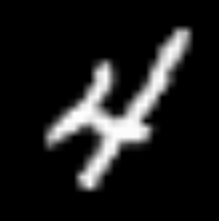

In [18]:
# Show image
file2 = "./input/sample_4.png"
Image.open(file2)

In [20]:
# Load & transform image
ori_img = Image.open(file2).convert('L')
t = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
img = torch.autograd.Variable(t(ori_img).unsqueeze(0))
ori_img.close()

In [21]:
# Predict
model.eval()
output = model(img)
pred = output.data.max(1, keepdim=True)[1][0][0]
print('Prediction: {}'.format(pred))

Prediction: 4


### Prediction: digit 6

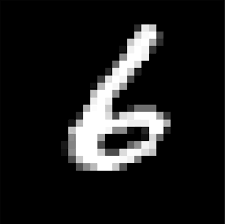

In [22]:
# Show image
file3 = "./input/sample_6.png"
Image.open(file3)

In [23]:
# Load & transform image
ori_img = Image.open(file3).convert('L')
t = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
img = torch.autograd.Variable(t(ori_img).unsqueeze(0))
ori_img.close()

In [24]:
# Predict
model.eval()
output = model(img)
pred = output.data.max(1, keepdim=True)[1][0][0]
print('Prediction: {}'.format(pred))

Prediction: 6
